# CNN GAN 

GAN based on 1D Convolutions. Inspired by WaveGAN [1].
Implementation based on [2].

[1] C. Donahue, J. McAuley, and M. Puckette, “Adversarial Audio Synthesis.” arXiv, Feb. 08, 2019.
Accessed: May 18, 2023. [Online]. Available: [https://arxiv.org/abs/1802.04208](https://arxiv.org/abs/1802.04208)
[2] Mostafa ElAraby, “Pytorch Implementation of WaveGAN Model to Generate Audio,”
GitHub. Accessed: Nov. 11, 2023. [Online]. Available: [https://github.com/mostafaelaraby/wavegan-pytorch](https://github.com/mostafaelaraby/wavegan-pytorch)

In [1]:
%load_ext autoreload
%autoreload 2
import os


RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
    # Move to default colab folder
    %cd /content
    # Check if repository is already cloned
    if not os.path.isdir("stg"):
        # Clone repository
        !git clone https://github.com/erik-buchholz/SoK-TrajGen.git stg
    # Change to repository directory
    %cd stg
    # Only install requirements not already installed by Colab
    !pip install opacus
    # SLOW: Only execute the following line if you encounter an error regarding a package not being installed
    # !pip install -r requirements.txt
else:
    import sys
    sys.path.append('..')  # Required for finding the `stg` module

In [2]:
import logging

import torch
from torch.utils.data import DataLoader

from stg.datasets import TrajectoryDataset, get_dataset, Datasets, DatasetModes
from stg.datasets.padding import ZeroPadding
from stg.models.cnn_gan import CNN_GAN
from stg.models.utils import load_model, prepare_param_path
from stg.models.utils import visualize_mnist_sequential, visualize_trajectory_samples
from stg.utils.helpers import count_parameters_torch
from stg.utils.logger import configure_root_loger

configure_root_loger(logging_level=logging.INFO)
# Parameters
GPU = 0
DEVICE = f"cuda:{GPU}" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cuda:0


## MNIST Sequential

First we try the model on a simple dataset.

In [3]:
# Parameters
OUTPUT_DIM = 28  # Number of feature dims
MAX_LENGTH = 28  # Max length of a sequence
BATCH_SIZE = 32
NOISE_DIM = 100
SAVE_FREQ = 50

WGAN = True
WGAN_GP = True
WGAN_LP = True
N_CRITIC = 1
OPT = "adamw"
LR_G = 1e-4
LR_D = 3e-4
BETA = (0.5, 0.999)

# Load dataset
mnist_dataset: TrajectoryDataset = get_dataset(dataset_name=Datasets.MNIST_SEQUENTIAL, mode=DatasetModes.TRAIN, latlon_only=True, return_labels=True)
mnist_dataloader = DataLoader(mnist_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
sample_batch = next(iter(mnist_dataloader))[0]
print(f"Shape of one Batch: {sample_batch.shape}")

Shape of one Batch: torch.Size([32, 28, 28])


In [4]:
MODEL_NAME = "CNN_GAN_MNIST_iWGAN"
# MODEL_NAME = "CNN_GAN_MNIST_GAN"
logging.getLogger().setLevel(logging.INFO)

# Create Model
cg_mnist = CNN_GAN(
    gpu=GPU,
    output_dim=OUTPUT_DIM,
    output_length=MAX_LENGTH,
    noise_dim=NOISE_DIM,
    upsample=False,
    name=MODEL_NAME,
).to(device=DEVICE)
# Test forward pass

# Generate noise
z = torch.randn(BATCH_SIZE, NOISE_DIM).to(device=DEVICE)
generated = cg_mnist(z)
print(f"Shape of generated:\t\t\t\t{generated.shape}")

# Run discriminator
discriminator_output = cg_mnist.dis(generated)
print(f"Shape of discriminator output:\t{discriminator_output.shape}")

# Compute # dis params / # gen params
print(f"Parameters Dis \ Gen:\t\t\t{count_parameters_torch(cg_mnist.dis, print_layers=False) / count_parameters_torch(cg_mnist.gen, print_layers=False):.2f}")

[2024-02-04 15:33:43,961][INFO   ] Discriminator Parameters:	13,406,429 (cnn_gan.py:496) 
[2024-02-04 15:33:43,963][INFO   ] Generator Parameters:	15,000,468 (cnn_gan.py:497) 
[2024-02-04 15:33:43,964][INFO   ] Proportion:			0.89 (cnn_gan.py:498) 
Shape of generated:				torch.Size([32, 28, 28])
Shape of discriminator output:	torch.Size([32, 1])
Parameters Dis \ Gen:			0.89


In [5]:
TRAIN = False
EPOCHS = 300

if TRAIN:
    cg_mnist.training_loop(
        dataloader=mnist_dataloader,
        epochs=EPOCHS,
        dataset_name=Datasets.MNIST_SEQUENTIAL,
        notebook=True,
        save_freq=SAVE_FREQ,
        plot_freq=len(mnist_dataloader) // 2,
        tensorboard=False,
        wgan=WGAN,
        gradient_penalty=WGAN_GP,  # WaveGAN uses WGAN-GP
        lp=WGAN_LP,
        n_critic=N_CRITIC,
        opt_g=OPT,
        opt_d=OPT,
        lr_g=LR_G,
        lr_d=LR_D,
        beta1=BETA[0],
        beta2=BETA[1], 
    )
else:
    try:
        load_model(cg_mnist.gen, cg_mnist.param_path, epoch=EPOCHS, device=DEVICE, model_str="GEN")
        load_model(cg_mnist.dis, cg_mnist.param_path, epoch=EPOCHS, device=DEVICE, model_str="DIS")
        # cg_mnist.load_parameters(epoch=EPOCHS)
    except RuntimeError:
        print("No model found")
# cg_mnist.save_parameters(epoch=EPOCHS)

[2024-02-04 15:33:45,842][INFO   ] Loaded model from '/home/erik/project2/parameters/CNN_GAN_MNIST_iWGAN/300_GEN.pth'. (utils.py:345) 
[2024-02-04 15:33:45,902][INFO   ] Loaded model from '/home/erik/project2/parameters/CNN_GAN_MNIST_iWGAN/300_DIS.pth'. (utils.py:345) 


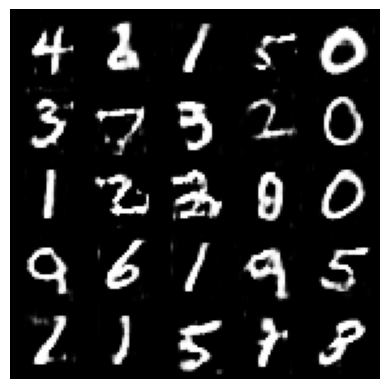

In [6]:
# Generate 25 samples and display
cg_mnist.eval()

z = torch.randn(25, NOISE_DIM).to(device=DEVICE)
generated = cg_mnist.gen(z)

visualize_mnist_sequential(generated, batches_done=0, notebook=True)

## Foursquare NYC

In [7]:
# Parameters
OUTPUT_DIM = 2  # Number of feature dims
BATCH_SIZE = 32
NOISE_DIM = 100
MODEL_NAME = "CNN_GAN_FS_iWGAN"
# MODEL_NAME = "CNN_GAN_FS_GAN_G-AdamW:0.0001_1xD-AdamW:0.0001"

# Load dataset
fs_dataset: TrajectoryDataset = get_dataset(dataset_name=Datasets.FS, mode=DatasetModes.TRAIN, latlon_only=True, return_labels=True)
MAX_LENGTH = fs_dataset.max_len  # Max length of a sequence
fs_dataloader = DataLoader(fs_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, collate_fn=ZeroPadding(True, True, fixed_length=MAX_LENGTH))
sample_batch = next(iter(fs_dataloader))
print(f"Shape of one Batch:\t\t{sample_batch[0].shape}")
print(f"Lengths:\t\t\t\t{len(sample_batch[1])} values - {str(sample_batch[1][:10]).replace(']',', ...]')}")
print(f"Labels:\t\t\t\t\t{len(sample_batch[2])} values - {str(sample_batch[2][:10]).replace(')',', ...)')}")
print(f"Max length:\t\t\t\t{MAX_LENGTH}")

[2024-02-04 15:33:46,154][INFO   ] Reading trajectories from '/home/erik/project2/data/fs_nyc/train_latlon.csv'. (fs_nyc.py:85) 
Shape of one Batch:		torch.Size([32, 144, 2])
Lengths:				32 values - [14, 39, 54, 28, 20, 13, 14, 20, 36, 17, ...]
Labels:					32 values - ('9744', '12566', '5209', '17998', '2733', '11070', '4621', '5832', '5194', '483', ...)
Max length:				144


In [8]:
logging.getLogger().setLevel(logging.INFO)

# Create Model
fs_gan = CNN_GAN(
    gpu=GPU,
    output_dim=OUTPUT_DIM,
    output_length=MAX_LENGTH,
    noise_dim=NOISE_DIM,
    upsample=False,
    use_batch_norm=False,
    name=MODEL_NAME,
).to(device=DEVICE)

# Test forward pass
z = torch.randn(BATCH_SIZE, NOISE_DIM).to(device=DEVICE)
generated = fs_gan(z)
print(f"Shape of generated:\t\t\t\t{generated.shape}")

discriminator_output = fs_gan.dis(generated)
print(f"Shape of discriminator output:\t{discriminator_output.shape}")

# Show layers of both
print("Discriminator:")
dis_params = count_parameters_torch(fs_gan.dis, print_layers=True)
print("Generator:")
gen_params = count_parameters_torch(fs_gan.gen, print_layers=True)

# Compute # dis params / # gen params
print(f"Parameters Dis \ Gen:\t\t\t{dis_params / gen_params:.2f}")

[2024-02-04 15:33:47,598][INFO   ] Discriminator Parameters:	77,127 (cnn_gan.py:496) 
[2024-02-04 15:33:47,599][INFO   ] Generator Parameters:	934,566 (cnn_gan.py:497) 
[2024-02-04 15:33:47,600][INFO   ] Proportion:			0.08 (cnn_gan.py:498) 
Shape of generated:				torch.Size([32, 144, 2])
Shape of discriminator output:	torch.Size([32, 1])
Discriminator:
[2024-02-04 15:33:47,616][INFO   ] conv_layers.0: 106 (helpers.py:56) 
[2024-02-04 15:33:47,617][INFO   ] conv_layers.1: 212 (helpers.py:56) 
[2024-02-04 15:33:47,618][INFO   ] conv_layers.2: 824 (helpers.py:56) 
[2024-02-04 15:33:47,619][INFO   ] conv_layers.3: 3248 (helpers.py:56) 
[2024-02-04 15:33:47,620][INFO   ] conv_layers.4: 12896 (helpers.py:56) 
[2024-02-04 15:33:47,621][INFO   ] conv_layers.5: 51392 (helpers.py:56) 
[2024-02-04 15:33:47,622][INFO   ] fc1.weight: 8448 (helpers.py:56) 
[2024-02-04 15:33:47,623][INFO   ] fc1.bias: 1 (helpers.py:56) 
Generator:
[2024-02-04 15:33:47,625][INFO   ] fc1.weight: 857600 (helpers.py:56) 

In [9]:
TRAIN = False
EPOCHS = 1000

if TRAIN:
    fs_gan.training_loop(
        dataloader=fs_dataloader,
        epochs=EPOCHS,
        dataset_name=Datasets.FS,
        notebook=True,
        save_freq=SAVE_FREQ,
        plot_freq=len(fs_dataloader) // 2,
        tensorboard=False,
        wgan=WGAN,
        gradient_penalty=WGAN_GP,  # WaveGAN uses WGAN-GP
        lp=WGAN_LP,
        n_critic=N_CRITIC,
        opt_g=OPT,
        opt_d=OPT,
        lr_g=LR_G,
        lr_d=LR_D,
        beta1=BETA[0],
        beta2=BETA[1],       
    )
else:
    fs_gan.load_parameters(epoch=EPOCHS)

[2024-02-04 15:33:47,706][INFO   ] Loaded model from '/home/erik/project2/parameters/CNN_GAN_FS_iWGAN/1000_COM.pth'. (utils.py:345) 


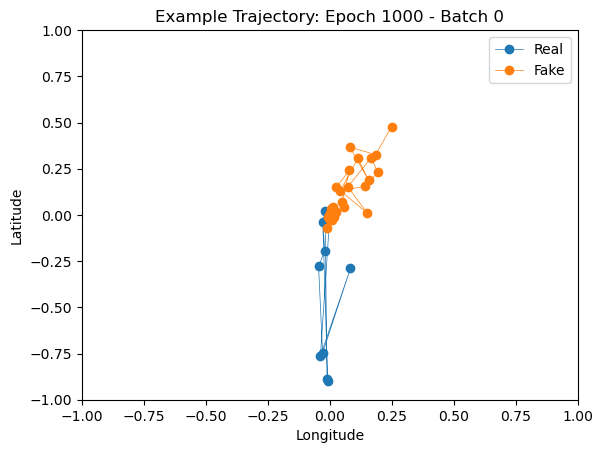

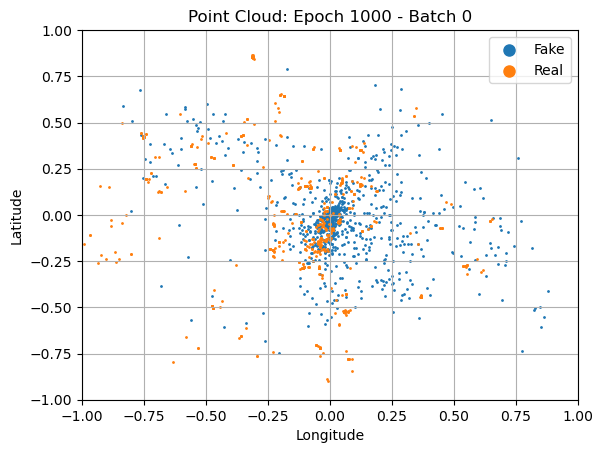

In [10]:
# Generate 
z = torch.randn(BATCH_SIZE, NOISE_DIM).to(device=DEVICE)
generated = fs_gan.gen(z)

# Sample same number of trajectories from dataset
real = next(iter(fs_dataloader))[0]

visualize_trajectory_samples(real_samples=real, gen_samples=generated, epoch=EPOCHS, batch_i=0, notebook=True)

## GeoLife

In [11]:
# Parameters
OUTPUT_DIM = 2  # Number of feature dims
BATCH_SIZE = 32
NOISE_DIM = 100
MODEL_NAME = "CNN_GAN_GEOLIFE_iWGAN"
# MODEL_NAME = "CNN_GAN_GEOLIFE_GAN_G-AdamW:0.0001_1xD-AdamW:0.0001"

# Load dataset
gl_dataset: TrajectoryDataset = get_dataset(dataset_name=Datasets.GEOLIFE, mode=DatasetModes.ALL, latlon_only=True, return_labels=True)
MAX_LENGTH = gl_dataset.max_len  # Max length of a sequence
gl_dataloader = DataLoader(gl_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, collate_fn=ZeroPadding(True, True, fixed_length=MAX_LENGTH))
sample_batch = next(iter(gl_dataloader))
print(f"Shape of one Batch:\t\t{sample_batch[0].shape}")
print(f"Lengths:\t\t\t\t{len(sample_batch[1])} values - {str(sample_batch[1][:10]).replace(']',', ...]')}")
print(f"Labels:\t\t\t\t\t{len(sample_batch[2])} values - {str(sample_batch[2][:10]).replace(')',', ...)')}")

[2024-02-04 15:33:48,470][WARNING] Make sure the reference point and scale factor computed during pre-processing are used! (geolife.py:122) 
[2024-02-04 15:33:48,472][INFO   ] Reading trajectories from '/home/erik/project2/data/geolife_FIFTH-RING_5_60_200_TRUNCATE'. (geolife.py:129) 
Shape of one Batch:		torch.Size([32, 200, 2])
Lengths:				32 values - [200, 16, 142, 186, 194, 200, 23, 200, 131, 49, ...]
Labels:					32 values - ('167_20081228032227_1', '010_20080922111517_1', '128_20101020082719_4', '022_20090721005532_2', '041_20090506062845_0', '041_20090708053310_9', '153_20080807045805_32', '036_20090304154229_2', '003_20090413050806_1', '022_20090422011155_36', ...)


In [12]:
logging.getLogger().setLevel(logging.INFO)

# Create Model
gl_gan = CNN_GAN(
    gpu=GPU,
    output_dim=OUTPUT_DIM,
    output_length=MAX_LENGTH,
    noise_dim=NOISE_DIM,
    upsample=False,
    use_batch_norm=False,
    name=MODEL_NAME,
).to(device=DEVICE)

# Test forward pass
z = torch.randn(BATCH_SIZE, NOISE_DIM).to(device=DEVICE)
generated = gl_gan(z)
print(f"Shape of generated:\t\t\t\t{generated.shape}")

discriminator_output = gl_gan.dis(generated)
print(f"Shape of discriminator output:\t{discriminator_output.shape}")

# Show layers of both
print("Discriminator:")
dis_params = count_parameters_torch(gl_gan.dis, print_layers=True)
print("Generator:")
gen_params = count_parameters_torch(gl_gan.gen, print_layers=True)

# Compute # dis params / # gen params
print(f"Parameters Dis \ Gen:\t\t\t{dis_params / gen_params:.2f}")

[2024-02-04 15:33:48,990][INFO   ] Discriminator Parameters:	80,711 (cnn_gan.py:496) 
[2024-02-04 15:33:48,991][INFO   ] Generator Parameters:	1,296,550 (cnn_gan.py:497) 
[2024-02-04 15:33:48,992][INFO   ] Proportion:			0.06 (cnn_gan.py:498) 
Shape of generated:				torch.Size([32, 200, 2])
Shape of discriminator output:	torch.Size([32, 1])
Discriminator:
[2024-02-04 15:33:49,008][INFO   ] conv_layers.0: 106 (helpers.py:56) 
[2024-02-04 15:33:49,010][INFO   ] conv_layers.1: 212 (helpers.py:56) 
[2024-02-04 15:33:49,011][INFO   ] conv_layers.2: 824 (helpers.py:56) 
[2024-02-04 15:33:49,012][INFO   ] conv_layers.3: 3248 (helpers.py:56) 
[2024-02-04 15:33:49,013][INFO   ] conv_layers.4: 12896 (helpers.py:56) 
[2024-02-04 15:33:49,014][INFO   ] conv_layers.5: 51392 (helpers.py:56) 
[2024-02-04 15:33:49,015][INFO   ] fc1.weight: 12032 (helpers.py:56) 
[2024-02-04 15:33:49,015][INFO   ] fc1.bias: 1 (helpers.py:56) 
Generator:
[2024-02-04 15:33:49,017][INFO   ] fc1.weight: 1216000 (helpers.py:

In [13]:
TRAIN = False
EPOCHS = 300

if TRAIN:
    gl_gan.training_loop(
        dataloader=gl_dataloader,
        epochs=EPOCHS,
        dataset_name='geolife',
        notebook=True,
        save_freq=50,
        plot_freq=len(gl_dataloader) // 2,
        tensorboard=False,
        wgan=WGAN,
        gradient_penalty=WGAN_GP,  # WaveGAN uses WGAN-GP
        lp=WGAN_LP,
        n_critic=N_CRITIC,
        opt_g=OPT,
        opt_d=OPT,
        lr_g=LR_G,
        lr_d=LR_D,
        beta1=BETA[0],
        beta2=BETA[1], 
        
    )
else:
    try:
        gl_gan.load_parameters(epoch=EPOCHS)
    except FileNotFoundError:
        print("No model found")

[2024-02-04 15:33:49,105][INFO   ] Loaded model from '/home/erik/project2/parameters/CNN_GAN_GEOLIFE_iWGAN/300_COM.pth'. (utils.py:345) 


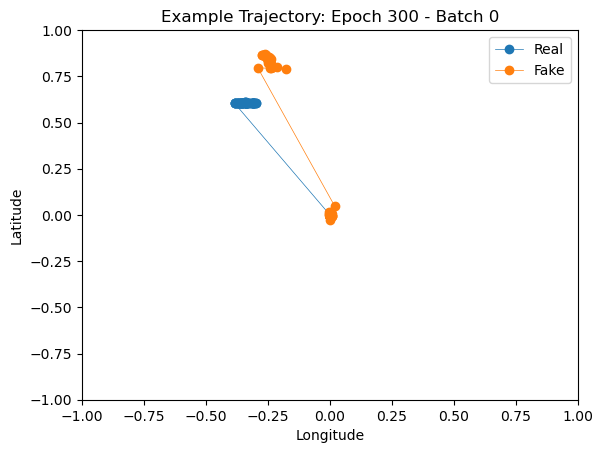

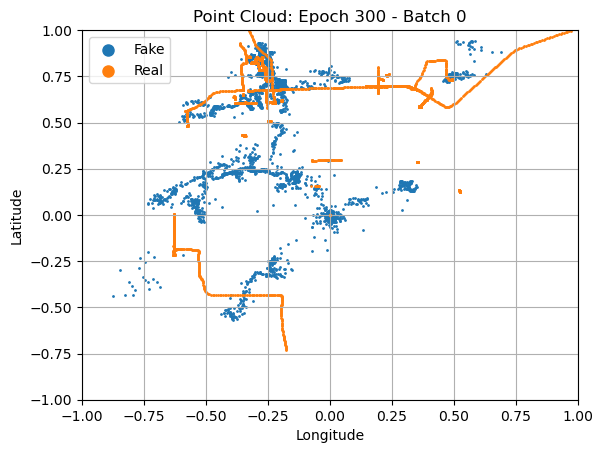

In [14]:
# Generate 
z = torch.randn(BATCH_SIZE, NOISE_DIM).to(device=DEVICE)
generated = gl_gan.gen(z)

# Sample same number of trajectories from dataset
real = next(iter(gl_dataloader))[0]

visualize_trajectory_samples(real_samples=real, gen_samples=generated, epoch=EPOCHS, batch_i=0, notebook=True)

## Original WaveGAN for comparison

Source: [https://github.com/mostafaelaraby/wavegan-pytorch/blob/master/models.py](https://github.com/mostafaelaraby/wavegan-pytorch/blob/master/models.py)

In [15]:
# All code in this cell is copied from Source: [https://github.com/mostafaelaraby/wavegan-pytorch/blob/master/models.py](https://github.com/mostafaelaraby/wavegan-pytorch/blob/master/models.py) for reference. 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data


class Transpose1dLayer(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride,
        padding=11,
        upsample=None,
        output_padding=1,
        use_batch_norm=False,
    ):
        super(Transpose1dLayer, self).__init__()
        self.upsample = upsample
        reflection_pad = nn.ConstantPad1d(kernel_size // 2, value=0)
        conv1d = nn.Conv1d(in_channels, out_channels, kernel_size, stride)
        conv1d.weight.data.normal_(0.0, 0.02)
        Conv1dTrans = nn.ConvTranspose1d(
            in_channels, out_channels, kernel_size, stride, padding, output_padding
        )
        batch_norm = nn.BatchNorm1d(out_channels)
        if self.upsample:
            operation_list = [reflection_pad, conv1d]
        else:
            operation_list = [Conv1dTrans]

        if use_batch_norm:
            operation_list.append(batch_norm)
        self.transpose_ops = nn.Sequential(*operation_list)

    def forward(self, x):
        if self.upsample:
            # recommended by wavegan paper to use nearest upsampling
            x = nn.functional.interpolate(x, scale_factor=self.upsample, mode="nearest")
        return self.transpose_ops(x)


class Conv1D(nn.Module):
    def __init__(
        self,
        input_channels,
        output_channels,
        kernel_size,
        alpha=0.2,
        shift_factor=2,
        stride=4,
        padding=11,
        use_batch_norm=False,
        drop_prob=0,
    ):
        super(Conv1D, self).__init__()
        self.conv1d = nn.Conv1d(
            input_channels, output_channels, kernel_size, stride=stride, padding=padding
        )
        self.batch_norm = nn.BatchNorm1d(output_channels)
        self.phase_shuffle = PhaseShuffle(shift_factor)
        self.alpha = alpha
        self.use_batch_norm = use_batch_norm
        self.use_phase_shuffle = shift_factor == 0
        self.use_drop = drop_prob > 0
        self.dropout = nn.Dropout2d(drop_prob)

    def forward(self, x):
        x = self.conv1d(x)
        if self.use_batch_norm:
            x = self.batch_norm(x)
        x = F.leaky_relu(x, negative_slope=self.alpha)
        if self.use_phase_shuffle:
            x = self.phase_shuffle(x)
        if self.use_drop:
            x = self.dropout(x)
        return x


class PhaseShuffle(nn.Module):
    """
    Performs phase shuffling, i.e. shifting feature axis of a 3D tensor
    by a random integer in {-n, n} and performing reflection padding where
    necessary.
    """

    # Copied from https://github.com/jtcramer/wavegan/blob/master/wavegan.py#L8
    def __init__(self, shift_factor):
        super(PhaseShuffle, self).__init__()
        self.shift_factor = shift_factor

    def forward(self, x):
        if self.shift_factor == 0:
            return x
        # uniform in (L, R)
        k_list = (
            torch.Tensor(x.shape[0]).random_(0, 2 * self.shift_factor + 1)
            - self.shift_factor
        )
        k_list = k_list.numpy().astype(int)

        # Combine sample indices into lists so that less shuffle operations
        # need to be performed
        k_map = {}
        for idx, k in enumerate(k_list):
            k = int(k)
            if k not in k_map:
                k_map[k] = []
            k_map[k].append(idx)

        # Make a copy of x for our output
        x_shuffle = x.clone()

        # Apply shuffle to each sample
        for k, idxs in k_map.items():
            if k > 0:
                x_shuffle[idxs] = F.pad(x[idxs][..., :-k], (k, 0), mode="reflect")
            else:
                x_shuffle[idxs] = F.pad(x[idxs][..., -k:], (0, -k), mode="reflect")

        assert x_shuffle.shape == x.shape, "{}, {}".format(x_shuffle.shape, x.shape)
        return x_shuffle


class WaveGANGenerator(nn.Module):
    def __init__(
        self,
        model_size=64,
        n_gpus=1,
        num_channels=1,
        verbose=False,
        upsample=True,
        slice_len=16384,
        use_batch_norm=False,
    ):
        super(WaveGANGenerator, self).__init__()
        assert slice_len in [16384, 32768, 65536]  # used to predict longer utterances

        self.n_gpus = n_gpus
        self.model_size = model_size  # d
        self.num_channels = num_channels  # c
        latent_dim = 100
        self.verbose = verbose
        self.use_batch_norm = use_batch_norm

        self.dim_mul = 16 if slice_len == 16384 else 32

        self.fc1 = nn.Linear(latent_dim, 4 * 4 * model_size * self.dim_mul)
        self.bn1 = nn.BatchNorm1d(num_features=model_size * self.dim_mul)

        stride = 4
        if upsample:
            stride = 1
            upsample = 4

        deconv_layers = [
            Transpose1dLayer(
                self.dim_mul * model_size,
                (self.dim_mul * model_size) // 2,
                25,
                stride,
                upsample=upsample,
                use_batch_norm=use_batch_norm,
            ),
            Transpose1dLayer(
                (self.dim_mul * model_size) // 2,
                (self.dim_mul * model_size) // 4,
                25,
                stride,
                upsample=upsample,
                use_batch_norm=use_batch_norm,
            ),
            Transpose1dLayer(
                (self.dim_mul * model_size) // 4,
                (self.dim_mul * model_size) // 8,
                25,
                stride,
                upsample=upsample,
                use_batch_norm=use_batch_norm,
            ),
            Transpose1dLayer(
                (self.dim_mul * model_size) // 8,
                (self.dim_mul * model_size) // 16,
                25,
                stride,
                upsample=upsample,
                use_batch_norm=use_batch_norm,
            ),
        ]

        if slice_len == 16384:
            deconv_layers.append(
                Transpose1dLayer(
                    (self.dim_mul * model_size) // 16,
                    num_channels,
                    25,
                    stride,
                    upsample=upsample,
                )
            )
        elif slice_len == 32768:
            deconv_layers += [
                Transpose1dLayer(
                    (self.dim_mul * model_size) // 16,
                    model_size,
                    25,
                    stride,
                    upsample=upsample,
                    use_batch_norm=use_batch_norm,
                ),
                Transpose1dLayer(model_size, num_channels, 25, 2, upsample=upsample),
            ]
        elif slice_len == 65536:
            deconv_layers += [
                Transpose1dLayer(
                    (self.dim_mul * model_size) // 16,
                    model_size,
                    25,
                    stride,
                    upsample=upsample,
                    use_batch_norm=use_batch_norm,
                ),
                Transpose1dLayer(
                    model_size, num_channels, 25, stride, upsample=upsample
                ),
            ]
        else:
            raise ValueError("slice_len {} value is not supported".format(slice_len))

        self.deconv_list = nn.ModuleList(deconv_layers)
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose1d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight.data)

    def forward(self, x):
        x = self.fc1(x).view(-1, self.dim_mul * self.model_size, 16)
        if self.use_batch_norm:
            x = self.bn1(x)
        x = F.relu(x)
        if self.verbose:
            print(x.shape)

        for deconv in self.deconv_list[:-1]:
            x = F.relu(deconv(x))
            if self.verbose:
                print(x.shape)
        output = torch.tanh(self.deconv_list[-1](x))
        return output


class WaveGANDiscriminator(nn.Module):
    def __init__(
        self,
        model_size=64,
        n_gpus=1,
        num_channels=1,
        shift_factor=2,
        alpha=0.2,
        verbose=False,
        slice_len=16384,
        use_batch_norm=False,
    ):
        super(WaveGANDiscriminator, self).__init__()
        assert slice_len in [16384, 32768, 65536]  # used to predict longer utterances

        self.model_size = model_size  # d
        self.n_gpus = n_gpus
        self.use_batch_norm = use_batch_norm
        self.num_channels = num_channels  # c
        self.shift_factor = shift_factor  # n
        self.alpha = alpha
        self.verbose = verbose

        conv_layers = [
            Conv1D(
                num_channels,
                model_size,
                25,
                stride=4,
                padding=11,
                use_batch_norm=use_batch_norm,
                alpha=alpha,
                shift_factor=shift_factor,
            ),
            Conv1D(
                model_size,
                2 * model_size,
                25,
                stride=4,
                padding=11,
                use_batch_norm=use_batch_norm,
                alpha=alpha,
                shift_factor=shift_factor,
            ),
            Conv1D(
                2 * model_size,
                4 * model_size,
                25,
                stride=4,
                padding=11,
                use_batch_norm=use_batch_norm,
                alpha=alpha,
                shift_factor=shift_factor,
            ),
            Conv1D(
                4 * model_size,
                8 * model_size,
                25,
                stride=4,
                padding=11,
                use_batch_norm=use_batch_norm,
                alpha=alpha,
                shift_factor=shift_factor,
            ),
            Conv1D(
                8 * model_size,
                16 * model_size,
                25,
                stride=4,
                padding=11,
                use_batch_norm=use_batch_norm,
                alpha=alpha,
                shift_factor=0 if slice_len == 16384 else shift_factor,
            ),
        ]
        self.fc_input_size = 256 * model_size
        if slice_len == 32768:
            conv_layers.append(
                Conv1D(
                    16 * model_size,
                    32 * model_size,
                    25,
                    stride=2,
                    padding=11,
                    use_batch_norm=use_batch_norm,
                    alpha=alpha,
                    shift_factor=0,
                )
            )
            self.fc_input_size = 480 * model_size
        elif slice_len == 65536:
            conv_layers.append(
                Conv1D(
                    16 * model_size,
                    32 * model_size,
                    25,
                    stride=4,
                    padding=11,
                    use_batch_norm=use_batch_norm,
                    alpha=alpha,
                    shift_factor=0,
                )
            )
            self.fc_input_size = 512 * model_size

        self.conv_layers = nn.ModuleList(conv_layers)

        self.fc1 = nn.Linear(self.fc_input_size, 1)

        for m in self.modules():
            if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight.data)

    def forward(self, x):
        for conv in self.conv_layers:
            x = conv(x)
            if self.verbose:
                print(x.shape)
        x = x.view(-1, self.fc_input_size)
        if self.verbose:
            print(x.shape)

        return self.fc1(x)

In [16]:
from stg.utils.helpers import count_parameters_torch

gen = WaveGANGenerator(verbose=True)
dis = WaveGANDiscriminator(verbose=True)

print(f"Generator:\t\t{count_parameters_torch(gen, print_layers=False):,}")
print(f"Discriminator:\t{count_parameters_torch(dis, print_layers=False):,}")
print(f"Dis / Gen:\t\t{count_parameters_torch(dis, print_layers=False) / count_parameters_torch(gen, print_layers=False):.2f}")

Generator:		19,067,393
Discriminator:	17,431,937
Dis / Gen:		0.91


In [17]:
z = torch.randn(1, 100)
generated = gen(z)
print(f"Shape of generated: {generated.shape}")
critic = dis(generated)
print(f"Shape of critic output: {critic.shape}")

torch.Size([1, 1024, 16])
torch.Size([1, 512, 64])
torch.Size([1, 256, 256])
torch.Size([1, 128, 1024])
torch.Size([1, 64, 4096])
Shape of generated: torch.Size([1, 1, 16384])
torch.Size([1, 64, 4096])
torch.Size([1, 128, 1024])
torch.Size([1, 256, 256])
torch.Size([1, 512, 64])
torch.Size([1, 1024, 16])
torch.Size([1, 16384])
Shape of critic output: torch.Size([1, 1])
